## Install dependencies ( colab )


In [ ]:
!pip install hopsworks --quiet
!pip install xgboost --quiet

## Data loading and basic pre-processing

### Get data from feature groups

In [ ]:
import hopsworks
import pandas as pd
import os
project = hopsworks.login(project="linneafr", api_key_value=os.getenv('HOPSWORKS_API_KEY'))

fs = project.get_feature_store()

air_quality_fg = fs.get_or_create_feature_group(
    name = 'air_quality_fg',
    version = 1
)
weather_fg = fs.get_or_create_feature_group(
    name = 'weather_fg',
    version = 1
)

# Get feature groups
weather_df = weather_fg.select_all().read()
weather_df.rename(columns={'datetime':'date'}, inplace=True)
air_quality_df = air_quality_fg.select_all().read()



Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/5380


### Join dataframes and clean data ( feature groups slightly outdated )

In [29]:
joint_df = pd.merge(air_quality_df, weather_df)
joint_df = joint_df.sort_values(by=['date'], ignore_index=True).drop(['address', 'co','severerisk'], axis=1)
joint_df['precipprob'].replace(100, 1, inplace=True)
joint_df.replace(' ', '0', inplace=True)
joint_df = joint_df.fillna(0)
joint_df['pm25'] = joint_df['pm25'].astype(int)
joint_df['pm10'] = joint_df['pm10'].astype(int)
joint_df['no2'] = joint_df['no2'].astype(int)
joint_df['so2'] = joint_df['so2'].astype(int)
# Add labeled data for 1-day prediction
joint_df['aqi_next_day'] = joint_df['aqi'].shift(1)

## Model training ( 1-day predictions )

[22:45:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


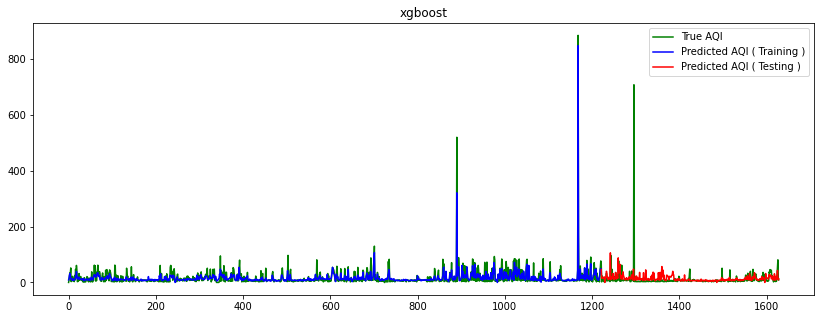

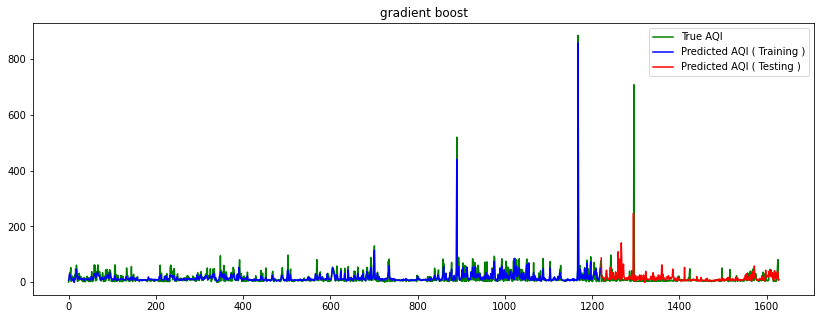

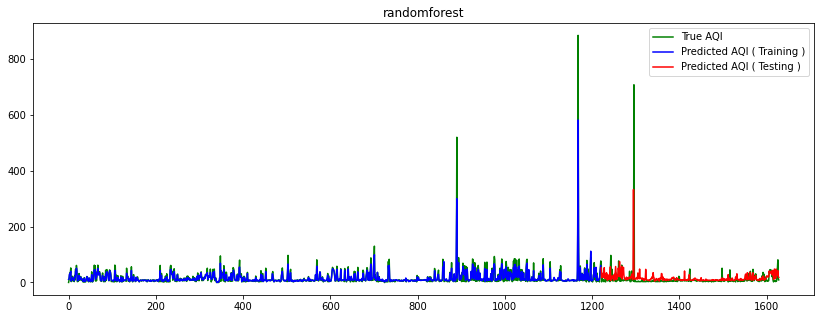

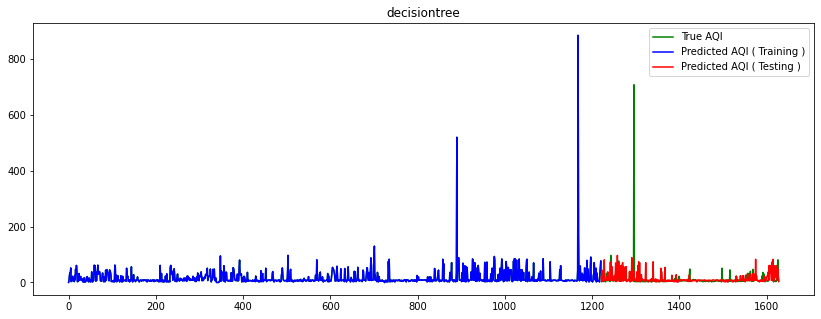

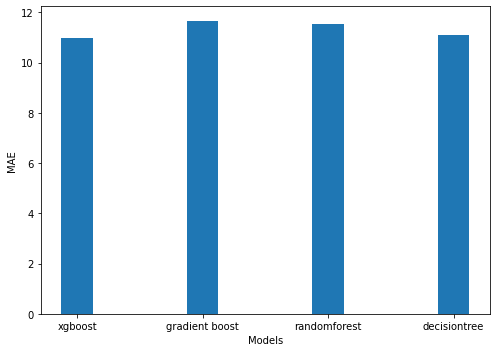

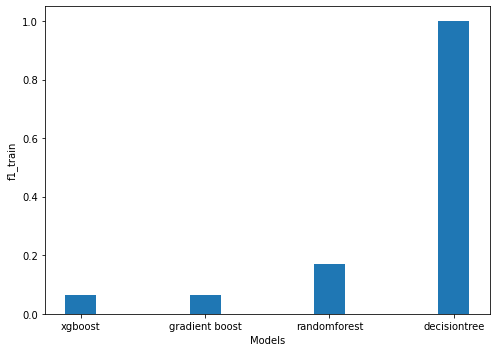

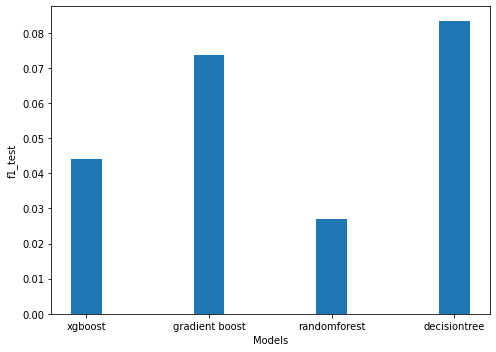

In [30]:
import xgboost
import numpy as np
from sklearn.metrics import f1_score, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def mape(y_true, y_pred):
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 2)

# Get train/test split
X = joint_df.drop(columns=['date']).fillna(0)
y = X.pop('aqi_next_day').values
X = X.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

# Candidate models
model_1 = xgboost.XGBRegressor(random_state=42)
model_2 = GradientBoostingRegressor(random_state=42)
model_3 = RandomForestRegressor(random_state=42)
model_4 = DecisionTreeRegressor(random_state=42)
models = [model_1, model_2, model_3, model_4]

model_names = ['xgboost', 'gradient boost', 'randomforest', 'decisiontree']
f1_scores_train = []
f1_scores_test = []
maes = []

# Evaluate models
for model_i, model in enumerate(models):
  scX=StandardScaler()
  scy=StandardScaler()
  X_train_t = scX.fit_transform(X_train)
  y_train_t = scy.fit_transform(y_train.reshape(-1,1))
  model.fit(X_train_t, y_train_t)
  test_preds = scy.inverse_transform(model.predict(scX.transform(X_test)).reshape(-1,1)).squeeze().astype('int')
  train_preds = scy.inverse_transform(model.predict(X_train_t).reshape(-1,1)).squeeze().astype('int')
  f1_scores_train.append(f1_score(y_train.astype('int'), train_preds,average='micro'))
  f1_scores_test.append(f1_score(y_test.astype('int'), test_preds,average='micro'))
  maes.append(mean_absolute_error(y_test, test_preds))

  test_preds_x = [t + len(train_preds) for t in range(len(test_preds))]
  fig = plt.figure(figsize=(14,5))
  plt.plot(y, label='True AQI', color='green')
  plt.plot(train_preds, label='Predicted AQI ( Training )', color='blue')
  plt.plot(test_preds_x, test_preds, label='Predicted AQI ( Testing )', color='red')
  plt.legend()
  plt.title(model_names[model_i])
  plt.show()

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(model_names, maes, width=0.25)
ax.set_xlabel('Models')
ax.set_ylabel('MAE')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(model_names, f1_scores_train, width=0.25)
ax.set_xlabel('Models')
ax.set_ylabel('f1_train')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(model_names, f1_scores_test, width=0.25)
ax.set_xlabel('Models')
ax.set_ylabel('f1_test')
plt.tight_layout()

    

## Feature selection for multi-day forecasting

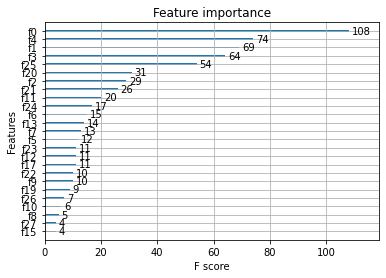

In [31]:
from xgboost import plot_importance

plot_importance(models[0])

In [ ]:
X2 = joint_df.drop(columns=['date', 'aqi_next_day']).fillna(0)
print('---- Current columns ----\n')
print(X2.columns)
print('\n---- Columns to drop ----\n')
print(X2.iloc[:, [27,26,23,22,19,17,15,12,10,9,8]].columns)
X2.drop(X2.iloc[:, [27,26,23,22,19,17,15,12,10,9,8]],axis = 1, inplace=True) # Threshholded at 12
print('\n---- New columns ----\n')
print(X2.columns)

'''
---- Current columns ----

['pm25', 'pm10', 'no2', 'so2', 'aqi', 'tempmax', 'tempmin', 'temp',
       'feelslikemax', 'feelslikemin', 'feelslike', 'dew', 'humidity',
       'precip', 'precipprob', 'precipcover', 'preciptype', 'snow',
       'snowdepth', 'windgust', 'windspeed', 'winddir', 'sealevelpressure',
       'cloudcover', 'visibility', 'solarradiation', 'solarenergy', 'uvindex']

---- Columns to drop ----

['uvindex', 'solarenergy', 'cloudcover', 'sealevelpressure', 'windgust',
       'snow', 'precipcover', 'humidity', 'feelslike', 'feelslikemin',
       'feelslikemax']

---- New columns ----

['pm25', 'pm10', 'no2', 'so2', 'aqi', 'tempmax', 'tempmin', 'temp',
       'dew', 'precip', 'precipprob', 'preciptype', 'snowdepth', 'windspeed',
       'winddir', 'visibility', 'solarradiation']
'''

## Transform data such that each datapoint contains 7 days weather forecast

In [42]:
from sklearn.multioutput import RegressorChain

def daily_to_weekly(df, aqi_cols):
    df_temp = pd.DataFrame()
    for column in df.columns:
        if column not in aqi_cols:
            for i in range(0,7):
                df_temp[f'{column}_{i}'] = df[column].shift(-i)
        else:
            df_temp[column] = df[column]
        
    for i in range(0,7):
        df_temp[f'y_{i}'] = df['aqi'].shift(-i)
    df_temp = df_temp.dropna(axis=0)
    
    return df_temp

aqi_cols = ['pm25', 'pm10', 'no2', 'so2', 'aqi']
X3 = daily_to_weekly(X2, aqi_cols)

X3.tail()

,pm25,pm10,no2,so2,aqi,tempmax_0,tempmax_1,tempmax_2,tempmax_3,tempmax_4,...,solarradiation_4,solarradiation_5,solarradiation_6,y_0,y_1,y_2,y_3,y_4,y_5,y_6
1618,0,5,24,0,5.0,-2.8,-5.9,-4.1,-0.1,-3.2,...,1.8,1.4,1.9,5.0,7.0,3.0,8.0,5.0,27.0,55.0
1619,0,7,3,0,7.0,-5.9,-4.1,-0.1,-3.2,-1.7,...,1.4,1.9,2.1,7.0,3.0,8.0,5.0,27.0,55.0,81.0
1620,0,3,1,0,3.0,-4.1,-0.1,-3.2,-1.7,-5.1,...,1.9,2.1,2.2,3.0,8.0,5.0,27.0,55.0,81.0,11.0
1621,0,7,8,0,8.0,-0.1,-3.2,-1.7,-5.1,-5.0,...,2.1,2.2,1.3,8.0,5.0,27.0,55.0,81.0,11.0,9.0
1622,0,5,18,0,5.0,-3.2,-1.7,-5.1,-5.0,-9.0,...,2.2,1.3,1.2,5.0,27.0,55.0,81.0,11.0,9.0,14.0


## Train models

[22:56:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[22:56:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


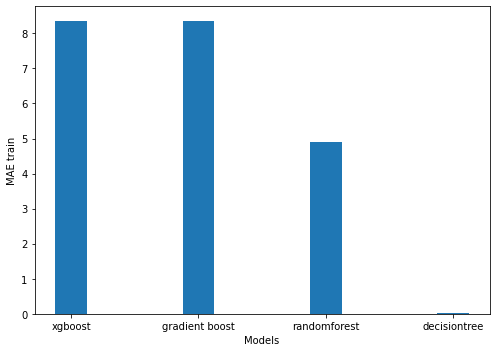

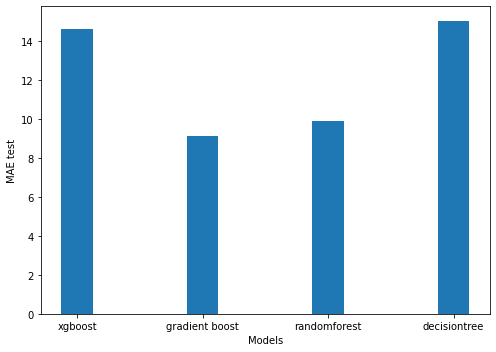

In [43]:
y_cols = [col for col in X3.columns if col.startswith('y')]
y3 = X3[y_cols].values
X3.drop(columns=y_cols, inplace=True)
X3 = X3.values

X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=0.15, random_state=42, shuffle=False)

model_1 = RegressorChain(xgboost.XGBRegressor(random_state=42))
model_2 = RegressorChain(GradientBoostingRegressor(random_state=42))
model_3 = RandomForestRegressor(random_state=42)
model_4 = DecisionTreeRegressor(random_state=42)
models = [model_1, model_2, model_3, model_4]

model_names = ['xgboost', 'gradient boost', 'randomforest', 'decisiontree']
maes_train = []
maes_test = []


for model_i, model in enumerate(models):
  scX=StandardScaler()
  scy=StandardScaler()
  X_train_t = scX.fit_transform(X_train)
  y_train_t = scy.fit_transform(y_train.reshape(-1,7))
  model.fit(X_train_t, y_train_t)
  test_preds = scy.inverse_transform(model.predict(scX.transform(X_test)).reshape(-1,7)).squeeze().astype('int')
  train_preds = scy.inverse_transform(model.predict(X_train_t).reshape(-1,7)).squeeze().astype('int')
  maes_test.append(mean_absolute_error(y_test, test_preds))
  maes_train.append(mean_absolute_error(y_train, train_preds))

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(model_names, maes_train, width=0.25)
ax.set_xlabel('Models')
ax.set_ylabel('MAE train')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(model_names, maes_test, width=0.25)
ax.set_xlabel('Models')
ax.set_ylabel('MAE test')
plt.tight_layout()

## Train multiple versions of best performing models (gb + rf) + compare median error

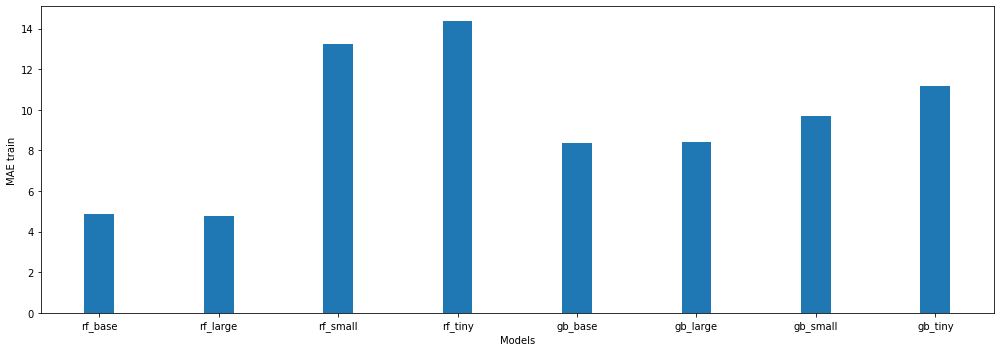

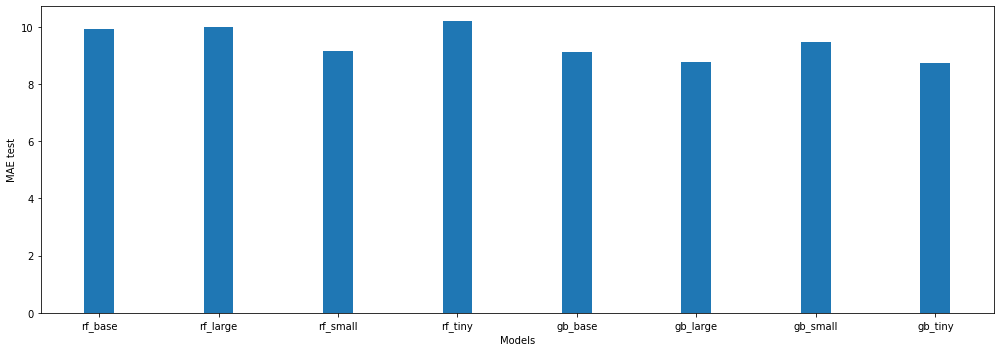

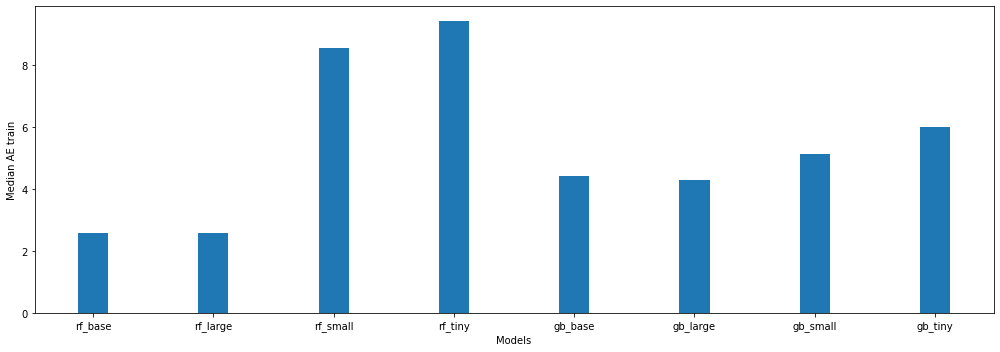

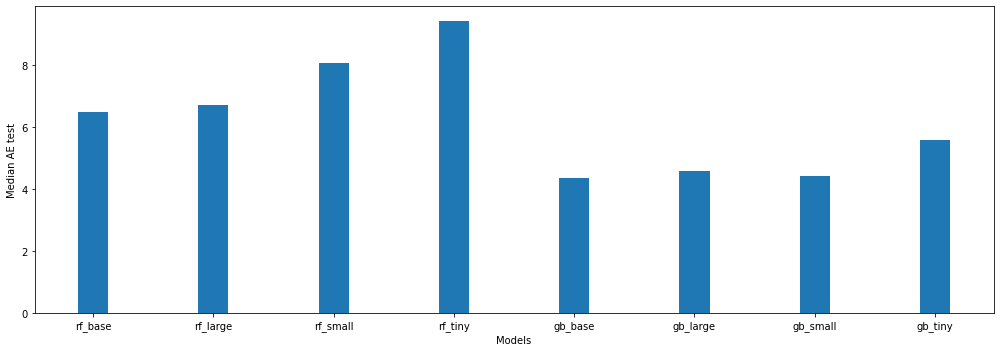

In [47]:
from sklearn.metrics import median_absolute_error

model_1 = RandomForestRegressor(random_state=42)
model_2 = RandomForestRegressor(random_state=42, n_estimators=1000)
model_3 = RandomForestRegressor(random_state=42, max_depth=2)
model_4 = RandomForestRegressor(random_state=42, max_depth=1)
model_5 = RegressorChain(GradientBoostingRegressor(random_state=42))
model_6 = RegressorChain(GradientBoostingRegressor(random_state=42, learning_rate=0.01, n_estimators=1000))
model_7 = RegressorChain(GradientBoostingRegressor(random_state=42, max_depth=2))
model_8 = RegressorChain(GradientBoostingRegressor(random_state=42, max_depth=1))
models = [model_1, model_2, model_3, model_4, model_5, model_6, model_7, model_8]

model_names = ['rf_base', 'rf_large', 'rf_small', 'rf_tiny', 'gb_base', 'gb_large', 'gb_small', 'gb_tiny']
maes_train = []
maes_test = []
meaes_train = []
meaes_test = []

scX=StandardScaler()
scy=StandardScaler()
X_train_t = scX.fit_transform(X_train)
y_train_t = scy.fit_transform(y_train.reshape(-1,7))

for model_i, model in enumerate(models):
  model.fit(X_train_t, y_train_t)
  test_preds = scy.inverse_transform(model.predict(scX.transform(X_test)).reshape(-1,7)).squeeze().astype('int')
  train_preds = scy.inverse_transform(model.predict(X_train_t).reshape(-1,7)).squeeze().astype('int')
  maes_test.append(mean_absolute_error(y_test, test_preds))
  maes_train.append(mean_absolute_error(y_train, train_preds))
  meaes_test.append(median_absolute_error(y_test, test_preds))
  meaes_train.append(median_absolute_error(y_train, train_preds))

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(model_names, maes_train, width=0.25)
ax.set_xlabel('Models')
ax.set_ylabel('MAE train')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(model_names, maes_test, width=0.25)
ax.set_xlabel('Models')
ax.set_ylabel('MAE test')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(model_names, meaes_train, width=0.25)
ax.set_xlabel('Models')
ax.set_ylabel('Median AE train')
plt.tight_layout()

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(model_names, meaes_test, width=0.25)
ax.set_xlabel('Models')
ax.set_ylabel('Median AE test')
plt.tight_layout()

## Train best models on full dataset and upload to model registry

In [49]:
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib

mr = project.get_model_registry()

model_1 = RandomForestRegressor(random_state=42)
model_2 = RandomForestRegressor(random_state=42, n_estimators=1000)
model_5 = RegressorChain(GradientBoostingRegressor(random_state=42))
model_6 = RegressorChain(GradientBoostingRegressor(random_state=42, learning_rate=0.01, n_estimators=1000))
model_7 = RegressorChain(GradientBoostingRegressor(random_state=42, max_depth=2))
model_8 = RegressorChain(GradientBoostingRegressor(random_state=42, max_depth=1))
models = [model_1, model_2, model_5, model_6, model_7, model_8]

model_names = ['rf_base', 'rf_large', 'gb_base_v2', 'gb_large_v2', 'gb_small_v2', 'gb_tiny_v2']
scX=StandardScaler()
scy=StandardScaler()

X_train_t = scX.fit_transform(X3)
y_train_t = scy.fit_transform(y3.reshape(-1,7))
for model_i, model in enumerate(models):
    model_name = model_names[model_i]

    model.fit(X_train_t, y_train_t)

    train_preds = scy.inverse_transform(model.predict(X_train_t).reshape(-1,7)).squeeze().astype('int')
    mae = mean_absolute_error(y3, train_preds)
    meae = median_absolute_error(y3, train_preds)

    input_schema = Schema(X_train_t)
    output_schema = Schema(y_train_t)
    model_schema = ModelSchema(input_schema=input_schema, output_schema=output_schema)

    joblib.dump(model, f'{model_name}.pkl')
    model = mr.python.create_model(
          name=model_name,
          metrics={"mean absolute error": mae, "median absolute error":meae},
          description=f"{model_name} : 7-day to 7-day air quality forecasting model, Reykjavík. Apply sklearn.standardscaler() before prediction",
          model_schema=model_schema
    )


Connected. Call `.close()` to terminate connection gracefully.


## Save standardscaler for inference use

In [ ]:
joblib.dump(scX, 'standardscalerX.bin', compress=True)
joblib.dump(scy, 'standardscalery.bin', compress=True)
